In [1]:
!pip install matplotlib numpy torchvision tqdm


[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: python -m pip install --upgrade pip



=== Training Task 1 ===


100%|██████████| 396/396 [00:00<00:00, 562.15it/s]


Epoch 1, Loss: 0.5126


100%|██████████| 396/396 [00:00<00:00, 473.09it/s]


Epoch 2, Loss: 0.2563
Accuracy on Task 1: 0.999

=== Training Task 2 ===


100%|██████████| 378/378 [00:00<00:00, 511.98it/s]


Epoch 1, Loss: 0.5874


100%|██████████| 378/378 [00:00<00:00, 436.53it/s]


Epoch 2, Loss: 0.3895
Accuracy on Task 1: 0.987
Accuracy on Task 2: 0.894

=== Training Task 3 ===


100%|██████████| 352/352 [00:00<00:00, 505.26it/s]


Epoch 1, Loss: 0.4752


100%|██████████| 352/352 [00:00<00:00, 442.23it/s]


Epoch 2, Loss: 0.3444
Accuracy on Task 1: 0.830
Accuracy on Task 2: 0.836
Accuracy on Task 3: 0.904

=== Training Task 4 ===


100%|██████████| 381/381 [00:00<00:00, 479.28it/s]


Epoch 1, Loss: 0.3774


100%|██████████| 381/381 [00:00<00:00, 453.79it/s]


Epoch 2, Loss: 0.1757
Accuracy on Task 1: 0.795
Accuracy on Task 2: 0.861
Accuracy on Task 3: 0.826
Accuracy on Task 4: 0.974

=== Training Task 5 ===


100%|██████████| 369/369 [00:00<00:00, 509.79it/s]


Epoch 1, Loss: 0.6420


100%|██████████| 369/369 [00:00<00:00, 442.16it/s]


Epoch 2, Loss: 0.3571
Accuracy on Task 1: 0.674
Accuracy on Task 2: 0.759
Accuracy on Task 3: 0.474
Accuracy on Task 4: 0.970
Accuracy on Task 5: 0.910
=== Continual Learning Metrics ===
Average Accuracy (ACC):       0.7572
Forgetting (F):              0.2235
Backward Transfer (BWT):     -0.2235
Forward Transfer (FWT):      0.0000
Memory Usage:                0.00 MB
Computation Cost:            0 projections/batch
Plasticity-Stability Measure (PSM): 0.3882 (0-1 normalized)


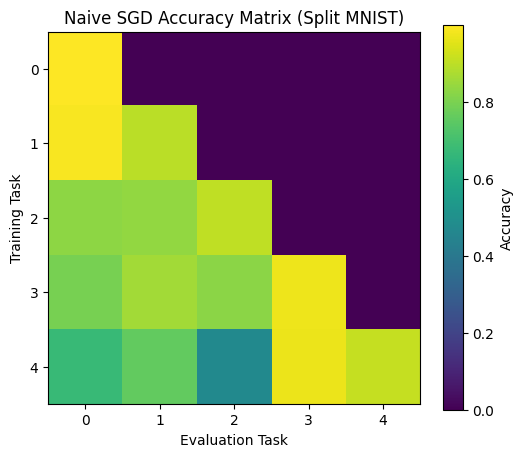

In [12]:
# Naive SGD on Split MNIST
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=2):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

# Naive SGD implementation
class NaiveSGD:
    def __init__(self, model, lr=0.001, device='cuda'):
        self.model = model.to(device)
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.device = device

    def observe(self, x, y, criterion=nn.CrossEntropyLoss()):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        loss = criterion(self.model(x), y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

# Prepare Split MNIST (5 tasks, 2 classes each)
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def split_dataset(dataset, classes):
    idx = np.isin(dataset.targets.numpy(), classes)
    data = dataset.data[idx].float()/255.0
    targets = dataset.targets[idx]
    mapping = {cls:i for i,cls in enumerate(classes)}
    targets = torch.tensor([mapping[t.item()] for t in targets])
    return TensorDataset(data.view(-1, 28*28), targets)

task_classes = [[0,1],[2,3],[4,5],[6,7],[8,9]]
train_tasks = [split_dataset(mnist_train, c) for c in task_classes]
test_tasks = [split_dataset(mnist_test, c) for c in task_classes]

# Training with Metrics
num_tasks = len(train_tasks)
num_epochs = 2
batch_size = 32

model = SimpleMLP(input_size=784, hidden_size=256, output_size=2)
sgd = NaiveSGD(model, lr=0.001, device=device)  

accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            loss = sgd.observe(x, y)
            epoch_loss += loss
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all tasks seen so far
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(sgd.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

# Compute Continual Learning Metrics
ACC = accuracy_matrix[-1].mean()  # Average Accuracy
F = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)])  # Forgetting
BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)])  # Backward Transfer
FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)])  # Forward Transfer

num_params = sum(p.numel() for p in sgd.model.parameters())
mem_usage = 0  # No memory stored in naive SGD
comp_cost = 0  # No projections

alpha = 0.5
PSM = alpha * (1 - F) + (1 - alpha) * max(FWT, 0)

# Print Metrics
print("=== Continual Learning Metrics ===")
print(f"Average Accuracy (ACC):       {ACC:.4f}")
print(f"Forgetting (F):              {F:.4f}")
print(f"Backward Transfer (BWT):     {BWT:.4f}")
print(f"Forward Transfer (FWT):      {FWT:.4f}")
print(f"Memory Usage:                {mem_usage:.2f} MB")
print(f"Computation Cost:            {comp_cost} projections/batch")
print(f"Plasticity-Stability Measure (PSM): {PSM:.4f} (0-1 normalized)")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('Naive SGD Accuracy Matrix (Split MNIST)')
plt.show()


=== Training Task 1 ===


100%|██████████| 1875/1875 [00:04<00:00, 395.75it/s]


Epoch 1, Loss: 2.1208


100%|██████████| 1875/1875 [00:04<00:00, 437.86it/s]


Epoch 2, Loss: 1.5742
Accuracy on Task 1: 0.799

=== Training Task 2 ===


100%|██████████| 1875/1875 [00:04<00:00, 435.70it/s]


Epoch 1, Loss: 1.7946


100%|██████████| 1875/1875 [00:04<00:00, 404.94it/s]


Epoch 2, Loss: 1.1227
Accuracy on Task 1: 0.785
Accuracy on Task 2: 0.825

=== Training Task 3 ===


100%|██████████| 1875/1875 [00:04<00:00, 421.13it/s]


Epoch 1, Loss: 1.5764


100%|██████████| 1875/1875 [00:04<00:00, 418.41it/s]


Epoch 2, Loss: 0.9323
Accuracy on Task 1: 0.780
Accuracy on Task 2: 0.814
Accuracy on Task 3: 0.840
=== Continual Learning Metrics ===
Average Accuracy (ACC):       0.8109
Forgetting (F):              0.0156
Backward Transfer (BWT):     -0.0156
Forward Transfer (FWT):      0.0000
Memory Usage:                0.00 MB
Computation Cost:            0 projections/batch
Plasticity-Stability Measure (PSM): 0.4922 (0-1 normalized)


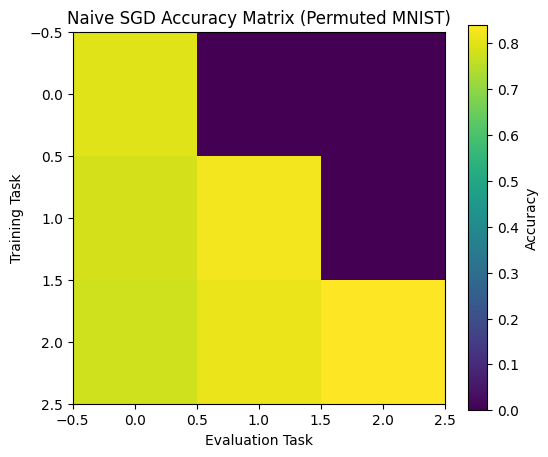

In [7]:
# Naive SGD on Permuted MNIST
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=10):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

# Naive SGD implementation
class NaiveSGD:
    def __init__(self, model, lr=0.001, device='cuda'):
        self.model = model.to(device)
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)
        self.device = device

    def observe(self, x, y, criterion=nn.CrossEntropyLoss()):
        self.model.train()
        x, y = x.to(self.device), y.to(self.device)
        self.optimizer.zero_grad()
        loss = criterion(self.model(x), y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

# Prepare Permuted MNIST
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

def permute_dataset(dataset, permutation):
    data = dataset.data.view(-1, 28*28).float() / 255.0
    data = data[:, permutation]
    targets = dataset.targets
    return TensorDataset(data, targets)

num_tasks = 3  # number of permuted tasks
perm_list = [torch.randperm(28*28) for _ in range(num_tasks)]
train_tasks = [permute_dataset(mnist_train, p) for p in perm_list]
test_tasks = [permute_dataset(mnist_test, p) for p in perm_list]

# Training with Metrics
num_epochs = 2
batch_size = 32

model = SimpleMLP(input_size=784, hidden_size=256, output_size=10)
sgd = NaiveSGD(model, lr=0.001, device=device)  

accuracy_matrix = np.zeros((num_tasks, num_tasks))

def evaluate_task(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Train
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            loss = sgd.observe(x, y)
            epoch_loss += loss
        print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

    # Evaluate on all tasks seen so far
    for eval_id in range(task_id+1):
        test_loader = DataLoader(test_tasks[eval_id], batch_size=batch_size, shuffle=False)
        acc = evaluate_task(sgd.model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

# Compute Continual Learning Metrics
ACC = accuracy_matrix[-1].mean()  # Average Accuracy
F = np.mean([np.max(accuracy_matrix[:num_tasks-1, j]) - accuracy_matrix[-1, j] for j in range(num_tasks-1)])  # Forgetting
BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_tasks-1)])  # Backward Transfer
FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_tasks-1)])  # Forward Transfer

num_params = sum(p.numel() for p in sgd.model.parameters())
mem_usage = 0  # No memory stored in naive SGD
comp_cost = 0  # No projections

alpha = 0.5
PSM = alpha * (1 - F) + (1 - alpha) * max(FWT, 0)

# Print Metrics
print("=== Continual Learning Metrics ===")
print(f"Average Accuracy (ACC):       {ACC:.4f}")
print(f"Forgetting (F):              {F:.4f}")
print(f"Backward Transfer (BWT):     {BWT:.4f}")
print(f"Forward Transfer (FWT):      {FWT:.4f}")
print(f"Memory Usage:                {mem_usage:.2f} MB")
print(f"Computation Cost:            {comp_cost} projections/batch")
print(f"Plasticity-Stability Measure (PSM): {PSM:.4f} (0-1 normalized)")

plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('Naive SGD Accuracy Matrix (Permuted MNIST)')
plt.show()

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Task 0: classes 0-9, train=5000, test=1000
Task 1: classes 10-19, train=5000, test=1000
Task 2: classes 20-29, train=5000, test=1000
Task 3: classes 30-39, train=5000, test=1000
Task 4: classes 40-49, train=5000, test=1000
Task 5: classes 50-59, train=5000, test=1000
Task 6: classes 60-69, train=5000, test=1000
Task 7: classes 70-79, train=5000, test=1000
Task 8: classes 80-89, train=5000, test=1000
Task 9: classes 90-99, train=5000, test=1000

=== Training Task 1 ===
Task 0 label range: min=0, max=9 (should be 0-9)


100%|██████████| 156/156 [00:00<00:00, 224.71it/s]


Epoch 1, Loss=2.3026


100%|██████████| 156/156 [00:00<00:00, 184.36it/s]


Epoch 2, Loss=2.3009
Accuracy on Task 1: 0.198

=== Training Task 2 ===
Task 1 label range: min=0, max=9 (should be 0-9)


100%|██████████| 156/156 [00:00<00:00, 200.39it/s]


Epoch 1, Loss=2.3014


100%|██████████| 156/156 [00:00<00:00, 184.88it/s]


Epoch 2, Loss=2.2981
Accuracy on Task 1: 0.100
Accuracy on Task 2: 0.100

=== Training Task 3 ===
Task 2 label range: min=0, max=9 (should be 0-9)


100%|██████████| 156/156 [00:00<00:00, 207.98it/s]


Epoch 1, Loss=2.3015


100%|██████████| 156/156 [00:00<00:00, 185.06it/s]


Epoch 2, Loss=2.2988
Accuracy on Task 1: 0.143
Accuracy on Task 2: 0.101
Accuracy on Task 3: 0.161

=== Training Task 4 ===
Task 3 label range: min=0, max=9 (should be 0-9)


100%|██████████| 156/156 [00:00<00:00, 209.17it/s]


Epoch 1, Loss=2.3015


100%|██████████| 156/156 [00:00<00:00, 184.96it/s]


Epoch 2, Loss=2.2987
Accuracy on Task 1: 0.098
Accuracy on Task 2: 0.100
Accuracy on Task 3: 0.092
Accuracy on Task 4: 0.101

=== Training Task 5 ===
Task 4 label range: min=0, max=9 (should be 0-9)


100%|██████████| 156/156 [00:00<00:00, 213.13it/s]


Epoch 1, Loss=2.3014


100%|██████████| 156/156 [00:00<00:00, 184.04it/s]


Epoch 2, Loss=2.2969
Accuracy on Task 1: 0.091
Accuracy on Task 2: 0.101
Accuracy on Task 3: 0.100
Accuracy on Task 4: 0.105
Accuracy on Task 5: 0.119

=== Training Task 6 ===
Task 5 label range: min=0, max=9 (should be 0-9)


100%|██████████| 156/156 [00:00<00:00, 213.94it/s]


Epoch 1, Loss=2.3017


100%|██████████| 156/156 [00:00<00:00, 184.01it/s]


Epoch 2, Loss=2.2984
Accuracy on Task 1: 0.108
Accuracy on Task 2: 0.128
Accuracy on Task 3: 0.076
Accuracy on Task 4: 0.120
Accuracy on Task 5: 0.098
Accuracy on Task 6: 0.166

=== Training Task 7 ===
Task 6 label range: min=0, max=9 (should be 0-9)


100%|██████████| 156/156 [00:00<00:00, 214.92it/s]


Epoch 1, Loss=2.3031


100%|██████████| 156/156 [00:00<00:00, 184.61it/s]


Epoch 2, Loss=2.2989
Accuracy on Task 1: 0.104
Accuracy on Task 2: 0.100
Accuracy on Task 3: 0.069
Accuracy on Task 4: 0.108
Accuracy on Task 5: 0.131
Accuracy on Task 6: 0.087
Accuracy on Task 7: 0.135

=== Training Task 8 ===
Task 7 label range: min=0, max=9 (should be 0-9)


100%|██████████| 156/156 [00:00<00:00, 206.56it/s]


Epoch 1, Loss=2.3043


100%|██████████| 156/156 [00:00<00:00, 184.44it/s]


Epoch 2, Loss=2.3028
Accuracy on Task 1: 0.110
Accuracy on Task 2: 0.110
Accuracy on Task 3: 0.124
Accuracy on Task 4: 0.114
Accuracy on Task 5: 0.093
Accuracy on Task 6: 0.043
Accuracy on Task 7: 0.104
Accuracy on Task 8: 0.136

=== Training Task 9 ===
Task 8 label range: min=0, max=9 (should be 0-9)


100%|██████████| 156/156 [00:00<00:00, 210.22it/s]


Epoch 1, Loss=2.3025


100%|██████████| 156/156 [00:00<00:00, 182.79it/s]


Epoch 2, Loss=2.3010
Accuracy on Task 1: 0.092
Accuracy on Task 2: 0.121
Accuracy on Task 3: 0.085
Accuracy on Task 4: 0.097
Accuracy on Task 5: 0.086
Accuracy on Task 6: 0.094
Accuracy on Task 7: 0.097
Accuracy on Task 8: 0.114
Accuracy on Task 9: 0.144

=== Training Task 10 ===
Task 9 label range: min=0, max=9 (should be 0-9)


100%|██████████| 156/156 [00:00<00:00, 205.34it/s]


Epoch 1, Loss=2.3015


100%|██████████| 156/156 [00:00<00:00, 184.49it/s]


Epoch 2, Loss=2.2991
Accuracy on Task 1: 0.101
Accuracy on Task 2: 0.101
Accuracy on Task 3: 0.080
Accuracy on Task 4: 0.096
Accuracy on Task 5: 0.104
Accuracy on Task 6: 0.101
Accuracy on Task 7: 0.109
Accuracy on Task 8: 0.090
Accuracy on Task 9: 0.114
Accuracy on Task 10: 0.123

=== Final Evaluation Metrics ===
ACC  : 0.1019
F    : 0.0470
BWT  : -0.0404
FWT  : 0.0000
PSM  : 0.4765


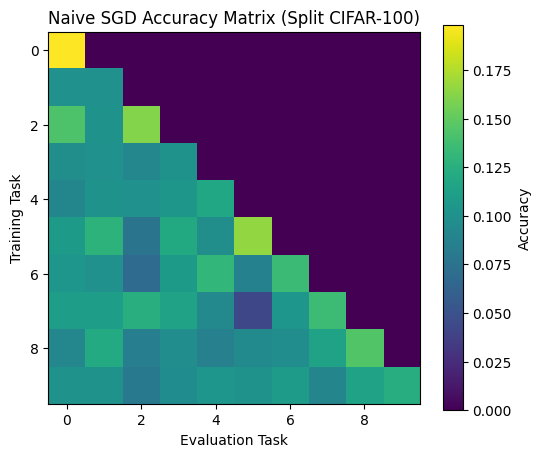

In [6]:
# Naive SGD on Split CIFAR-100
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Better CUDA error tracebacks

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===== Hyperparameters =====
root = './data'
num_tasks = 10
num_classes = 100
classes_per_task = num_classes // num_tasks
batch_size = 32
num_epochs = 2
learning_rate = 0.001

# ===== Transforms =====
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()

# ===== Load CIFAR-100 =====
train_ds = datasets.CIFAR100(root=root, train=True, download=True, transform=train_transform)
test_ds = datasets.CIFAR100(root=root, train=False, download=True, transform=test_transform)

# ===== Helper: extract subset =====
def extract_subset_tensors(dataset, class_list):
    targets = np.array(dataset.targets)
    mask = np.isin(targets, class_list)
    indices = np.nonzero(mask)[0].tolist()
    imgs, labs = [], []
    for i in indices:
        img, lbl = dataset[i]
        imgs.append(img)
        labs.append(lbl)
    return torch.stack(imgs), torch.tensor(labs, dtype=torch.long)

# ===== Prepare tasks =====
train_tasks, test_tasks = [], []
for t in range(num_tasks):
    cls_start = t * classes_per_task
    cls_end = cls_start + classes_per_task
    task_classes = list(range(cls_start, cls_end))

    x_train, y_train = extract_subset_tensors(train_ds, task_classes)
    x_test, y_test = extract_subset_tensors(test_ds, task_classes)

    # Map labels to 0..classes_per_task-1
    class_map = {orig: i for i, orig in enumerate(task_classes)}
    y_train_mapped = torch.tensor([class_map[int(v)] for v in y_train], dtype=torch.long)
    y_test_mapped = torch.tensor([class_map[int(v)] for v in y_test], dtype=torch.long)

    train_tasks.append(TensorDataset(x_train, y_train_mapped))
    test_tasks.append(TensorDataset(x_test, y_test_mapped))

    print(f"Task {t}: classes {task_classes[0]}-{task_classes[-1]}, train={len(x_train)}, test={len(x_test)}")

# ===== Simple CNN =====
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*8*8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ===== Evaluation function =====
def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y = y.long()
            output = model(x)
            preds = output.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

# ===== Training loop =====
accuracy_matrix = np.zeros((num_tasks, num_tasks))

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")

    # Create a fresh model per task
    model = SimpleCNN(num_classes=classes_per_task).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0
    )

    # Check label ranges
    y_all = torch.cat([y for _, y in train_loader])
    print(f"Task {task_id} label range: min={y_all.min().item()}, max={y_all.max().item()} (should be 0-{classes_per_task-1})")

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            y = y.long()
            optimizer.zero_grad()
            output = model(x)

            # Safeguard: assert labels are within range
            assert y.max().item() < output.size(1), f"Label {y.max().item()} out of range for {output.size(1)} classes"

            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss={epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(
            test_tasks[eval_id], batch_size=batch_size, shuffle=False, num_workers=0
        )
        acc = evaluate(model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

# ===== Metrics =====
num_seen_tasks = accuracy_matrix.shape[0]

# ACC: average accuracy over all tasks after training last task
ACC = accuracy_matrix[-1].mean()

# Forgetting F: average of max previous accuracy - final accuracy for each task
if num_seen_tasks > 1:
    F = np.mean([np.max(accuracy_matrix[:num_seen_tasks-1, j]) - accuracy_matrix[-1, j] 
                 for j in range(num_seen_tasks-1)])
    BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_seen_tasks-1)])
    FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_seen_tasks-1)])
else:
    F, BWT, FWT = 0.0, 0.0, 0.0

# Performance Stability Metric (PSM)
PSM = 0.5*(1-F) + 0.5*max(FWT,0)

print("\n=== Final Evaluation Metrics ===")
print(f"ACC  : {ACC:.4f}")
print(f"F    : {F:.4f}")
print(f"BWT  : {BWT:.4f}")
print(f"FWT  : {FWT:.4f}")
print(f"PSM  : {PSM:.4f}")

# ===== Plot accuracy matrix =====
plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('Naive SGD Accuracy Matrix (Split CIFAR-100)')
plt.show()

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Task 0: classes 0-1, train=1000, test=200
Task 1: classes 2-3, train=1000, test=200
Task 2: classes 4-5, train=1000, test=200
Task 3: classes 6-7, train=1000, test=200
Task 4: classes 8-9, train=1000, test=200

=== Training Task 1 ===
Task 0 label range: min=0, max=1 (should be 0-1)


100%|██████████| 31/31 [00:00<00:00, 405.73it/s]


Epoch 1, Loss=0.6832


100%|██████████| 31/31 [00:00<00:00, 349.15it/s]

Epoch 2, Loss=0.6788


Accuracy on Task 1: 0.525

=== Training Task 2 ===
Task 1 label range: min=0, max=1 (should be 0-1)


100%|██████████| 31/31 [00:00<00:00, 330.78it/s]


Epoch 1, Loss=0.6931


100%|██████████| 31/31 [00:00<00:00, 269.86it/s]


Epoch 2, Loss=0.6927
Accuracy on Task 1: 0.565
Accuracy on Task 2: 0.515

=== Training Task 3 ===
Task 2 label range: min=0, max=1 (should be 0-1)


100%|██████████| 31/31 [00:00<00:00, 282.44it/s]


Epoch 1, Loss=0.6955


100%|██████████| 31/31 [00:00<00:00, 247.21it/s]


Epoch 2, Loss=0.6927
Accuracy on Task 1: 0.615
Accuracy on Task 2: 0.485
Accuracy on Task 3: 0.475

=== Training Task 4 ===
Task 3 label range: min=0, max=1 (should be 0-1)


100%|██████████| 31/31 [00:00<00:00, 278.19it/s]


Epoch 1, Loss=0.6927


100%|██████████| 31/31 [00:00<00:00, 239.38it/s]


Epoch 2, Loss=0.6921
Accuracy on Task 1: 0.230
Accuracy on Task 2: 0.505
Accuracy on Task 3: 0.550
Accuracy on Task 4: 0.605

=== Training Task 5 ===
Task 4 label range: min=0, max=1 (should be 0-1)


100%|██████████| 31/31 [00:00<00:00, 282.26it/s]


Epoch 1, Loss=0.6930


100%|██████████| 31/31 [00:00<00:00, 244.83it/s]


Epoch 2, Loss=0.6926
Accuracy on Task 1: 0.495
Accuracy on Task 2: 0.500
Accuracy on Task 3: 0.500
Accuracy on Task 4: 0.500
Accuracy on Task 5: 0.500

=== Final Evaluation Metrics ===
ACC  : 0.4990
F    : 0.0725
BWT  : -0.0312
FWT  : 0.0000
PSM  : 0.4637


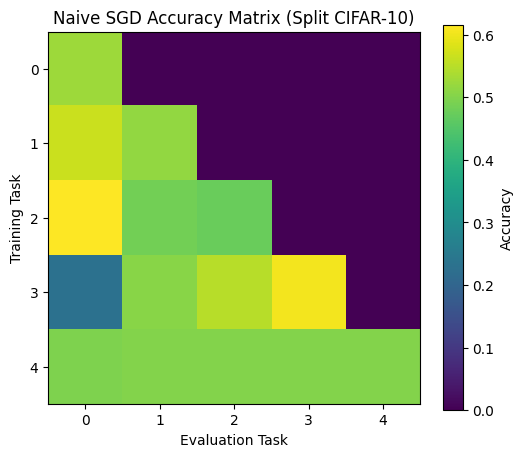

In [2]:
# Naive SGD on Split CIFAR-100
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"  # Better CUDA error tracebacks

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ===== Device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ===== Hyperparameters =====
root = './data'
num_tasks = 5
num_classes = 10
classes_per_task = num_classes // num_tasks
batch_size = 32
num_epochs = 2
learning_rate = 0.001

# ===== Transforms =====
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()

# ===== Load CIFAR-100 =====
train_ds = datasets.CIFAR100(root=root, train=True, download=True, transform=train_transform)
test_ds = datasets.CIFAR100(root=root, train=False, download=True, transform=test_transform)

# ===== Helper: extract subset =====
def extract_subset_tensors(dataset, class_list):
    targets = np.array(dataset.targets)
    mask = np.isin(targets, class_list)
    indices = np.nonzero(mask)[0].tolist()
    imgs, labs = [], []
    for i in indices:
        img, lbl = dataset[i]
        imgs.append(img)
        labs.append(lbl)
    return torch.stack(imgs), torch.tensor(labs, dtype=torch.long)

# ===== Prepare tasks =====
train_tasks, test_tasks = [], []
for t in range(num_tasks):
    cls_start = t * classes_per_task
    cls_end = cls_start + classes_per_task
    task_classes = list(range(cls_start, cls_end))

    x_train, y_train = extract_subset_tensors(train_ds, task_classes)
    x_test, y_test = extract_subset_tensors(test_ds, task_classes)

    # Map labels to 0..classes_per_task-1
    class_map = {orig: i for i, orig in enumerate(task_classes)}
    y_train_mapped = torch.tensor([class_map[int(v)] for v in y_train], dtype=torch.long)
    y_test_mapped = torch.tensor([class_map[int(v)] for v in y_test], dtype=torch.long)

    train_tasks.append(TensorDataset(x_train, y_train_mapped))
    test_tasks.append(TensorDataset(x_test, y_test_mapped))

    print(f"Task {t}: classes {task_classes[0]}-{task_classes[-1]}, train={len(x_train)}, test={len(x_test)}")

# ===== Simple CNN =====
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*8*8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# ===== Evaluation function =====
def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            y = y.long()
            output = model(x)
            preds = output.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total

# ===== Training loop =====
accuracy_matrix = np.zeros((num_tasks, num_tasks))

for task_id, train_dataset in enumerate(train_tasks):
    print(f"\n=== Training Task {task_id+1} ===")

    # Create a fresh model per task
    model = SimpleCNN(num_classes=classes_per_task).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=0
    )

    # Check label ranges
    y_all = torch.cat([y for _, y in train_loader])
    print(f"Task {task_id} label range: min={y_all.min().item()}, max={y_all.max().item()} (should be 0-{classes_per_task-1})")

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for x, y in tqdm(train_loader):
            x, y = x.to(device), y.to(device)
            y = y.long()
            optimizer.zero_grad()
            output = model(x)

            # Safeguard: assert labels are within range
            assert y.max().item() < output.size(1), f"Label {y.max().item()} out of range for {output.size(1)} classes"

            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss={epoch_loss/len(train_loader):.4f}")

    # Evaluate on all seen tasks
    for eval_id in range(task_id+1):
        test_loader = DataLoader(
            test_tasks[eval_id], batch_size=batch_size, shuffle=False, num_workers=0
        )
        acc = evaluate(model, test_loader)
        accuracy_matrix[task_id, eval_id] = acc
        print(f"Accuracy on Task {eval_id+1}: {acc:.3f}")

# ===== Metrics =====
num_seen_tasks = accuracy_matrix.shape[0]

# ACC: average accuracy over all tasks after training last task
ACC = accuracy_matrix[-1].mean()

# Forgetting F: average of max previous accuracy - final accuracy for each task
if num_seen_tasks > 1:
    F = np.mean([np.max(accuracy_matrix[:num_seen_tasks-1, j]) - accuracy_matrix[-1, j] 
                 for j in range(num_seen_tasks-1)])
    BWT = np.mean([accuracy_matrix[-1, j] - accuracy_matrix[j, j] for j in range(num_seen_tasks-1)])
    FWT = np.mean([accuracy_matrix[i, i+1] for i in range(num_seen_tasks-1)])
else:
    F, BWT, FWT = 0.0, 0.0, 0.0

# Performance Stability Metric (PSM)
PSM = 0.5*(1-F) + 0.5*max(FWT,0)

print("\n=== Final Evaluation Metrics ===")
print(f"ACC  : {ACC:.4f}")
print(f"F    : {F:.4f}")
print(f"BWT  : {BWT:.4f}")
print(f"FWT  : {FWT:.4f}")
print(f"PSM  : {PSM:.4f}")

# ===== Plot accuracy matrix =====
plt.figure(figsize=(6,5))
plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Accuracy')
plt.xlabel('Evaluation Task')
plt.ylabel('Training Task')
plt.title('Naive SGD Accuracy Matrix (Split CIFAR-10)')
plt.show()